In [40]:
import pandas as pd
import regex as re
import string
from matplotlib import pyplot as plt
import os

In [41]:
df = pd.read_pickle("./Data/MovieSummaries/plots_genres.pkl")
# Remove rows with empty genre
df = df[~df['genre'].apply(lambda x: len(x) == 0)]
#remove rows with nan genre
df = df[~df['genre'].isna()]

print(len(df))

41793


In [42]:
import pandas as pd

def process_less_than_threshold(df, count_threshold=50):
    df_exploded = df.explode('genre')

    # Count the occurrences of each string
    result = df_exploded['genre'].value_counts().reset_index()

    # Rename the columns for better clarity
    result.columns = ['String', 'Count']

    # Filter strings with count less than the threshold
    less_than_threshold = result[result['Count'] < count_threshold]
    less_than_threshold_list = less_than_threshold['String'].tolist()

    print(less_than_threshold_list)

    # Filter the original dataframe to remove rows containing less frequent genres
    df[df['genre'].apply(lambda x: any(target in x for target in less_than_threshold_list))]

    # Remove less frequent genres from the 'genre' column
    df['genre'] = df['genre'].apply(lambda x: [item for item in x if item not in less_than_threshold_list])

    # Remove rows with empty genre again
    df = df[~df['genre'].apply(lambda x: len(x) == 0)]

    return df

In [43]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove extra spaces
    text = re.sub(r' +', ' ', text)
    #remove leading and trailing spaces
    text = text.strip()
    return text

In [44]:
#write as function
def preprocess_genre(genre):
    genre = [preprocess_text(genre) for genre in genre]
    genre = [re.sub(r'\b(film|films|movie|movies|cinema|new|\'s)\b', '', genre) for genre in genre]
    genre = [genre.strip() for genre in genre]
    return genre

In [45]:
df['genre'] = df['genre'].apply(lambda x: preprocess_genre(x))

In [46]:
#clustering with TF-IDF (Term Frequency-Inverse Document Frequency) vectorization process in the provided code converts textual data (in this case, movie category names) into numerical vectors. 


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

#reduce categories
unique_categories = list(set([category for sublist in df['genre'] for category in sublist]))

# Extract category names
category_names = [category for category in unique_categories]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the category names using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(category_names)

# Perform K-means clustering with n clusters
kmeans = KMeans(n_clusters=15)
kmeans.fit(tfidf_matrix)

# Get the cluster labels for each category
cluster_labels = kmeans.labels_

# Create a dictionary to group categories by their cluster label
clusters = {}
for i, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(category_names[i])

# Print the movie categories grouped by "over genres"
for cluster_label, cluster_categories in clusters.items():
    print(f"Over Genre {cluster_label + 1}:")
    print(", ".join(cluster_categories))
    print()

c:\anaconda3\envs\nlp-project\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Over Genre 12:
, heavencanwait fantasies, remake, bollywood, punk rock, crime, patriotic, roadhorror, erotic thriller, americana, musical, scifi thriller, tragedy, psychobiddy, private military company, caper story, psychological thriller, world history, gay, foreign legion, hip hop, samurai, tokusatsu, gothic, thriller, actionadventure, stoner, mystery, school story, british empire, juvenile delinquency, environmental science, television, adult, about gladiators, comdedy, anthropology, neorealism, fan, tollywood, auto racing, master criminal, star vehicle, creature, early black, cult, feminist, history, erotica, educational, suspense, dogme, singing cowboy, biographical, roadshowcarny, surrealism, slasher, giallo, comedydrama, inventions innovations, nuclear warfare, biker, slapstick, superhero, ensemble, animated cartoon, teen, race, jukebox musical, hollywood, period piece, animated musical, backstage musical, swashbuckler, goat gland, pinku eiga, finance investing, sci fi pictures 

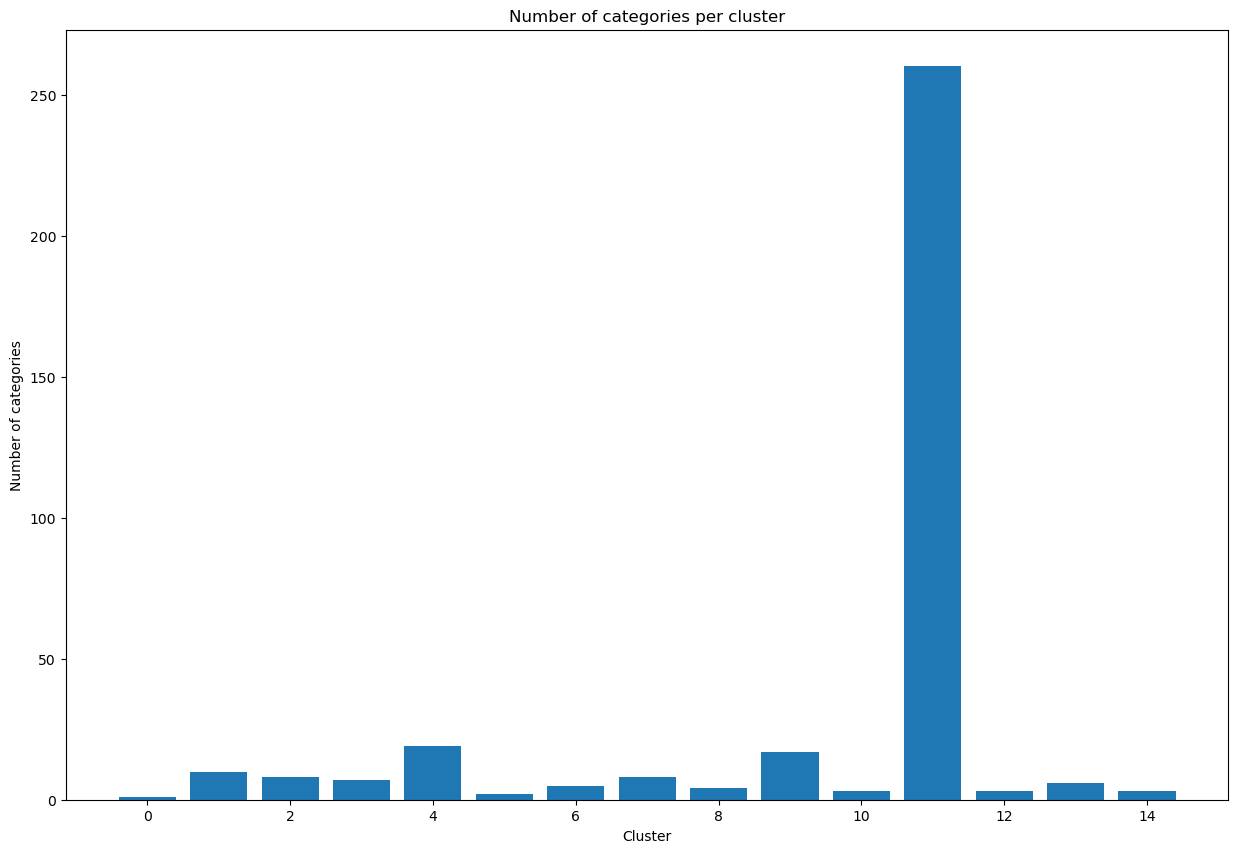

In [47]:
#show balance of clusters
plt.figure(figsize=(15,10))
plt.bar(clusters.keys(), [len(cluster) for cluster in clusters.values()])
plt.title('Number of categories per cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of categories')
plt.show()

In [48]:
# #Create a DataFrame from the 'clusters' dictionary
#if genre_clusters_tf-idf.csv already exists, skip this step
if not os.path.isfile('Data/MovieSummaries/genre_clusters_tf-idf.csv'):
    df_clusters = pd.DataFrame.from_dict(clusters, orient='index')

    #sort by index desc
    df_clusters = df_clusters.sort_index(ascending=True)
    #transpose
    df_clusters = df_clusters.transpose()

    # Write the DataFrame to a CSV file with a semicolon (;) separator
    df_clusters.to_csv('Data/MovieSummaries/genre_clusters_tf-idf.csv', index=False, sep=';')

#load the clusters from the csv file
df_clusters = pd.read_csv('Data/MovieSummaries/genre_clusters_tf-idf.csv', sep=';')

In [49]:
#count occurences of each cluster in orignal df
# iterate of each column of df_clusters, count for each element in the column how many times it appears in the original df and sum up the counts
# df_clusters_count = pd.DataFrame(df_clusters.apply(lambda x: df['genre'].apply(lambda y: x.isin(y).sum()).sum(), axis=0))
# df_clusters_count

# 	
# 0	651
# 1	22953
# 2	6756
# 3	1278
# 4	4644
# 5	3883
# 6	4016
# 7	6417
# 8	6626
# 9	735
# 10	981
# 11	341
# 12	73837
# 13	16678
# 14	668

In [50]:
# rename clusters to more meaningful names

new_column_names = {
    '0': 'suspense',
    '1': 'drama',
    '2': 'war',
    '3': 'western',
    '4': 'horror',
    '5': 'adventure',
    '6': 'family',
    '7': 'action',
    '8': 'crime',
    '9': 'gay',
    '10': 'political',
    '11': 'buddy',
    '12': 'miscellaneous',
    '13': 'comedy',
    '14': 'childrens'
}

# Rename the columns
df_clusters.rename(columns=new_column_names, inplace=True)

df_clusters
#remove column "miscellaneous"
df_clusters.drop('miscellaneous', axis=1, inplace=True)

In [51]:
#replace in df the genre categories with the cluster names
# Create a dictionary to map the clusters to the genre categories
cluster_genre_map = {}
for cluster_label, cluster_categories in df_clusters.items():
    for category in cluster_categories:
        cluster_genre_map[category] = cluster_label



In [52]:
# explode df['genre'] again and do the same as above
df_exploded = df.explode('genre')
#if key is in cluster_genre_map, replace with value
df_exploded['genre'] = df_exploded['genre'].apply(lambda x: cluster_genre_map[x] if x in dict(cluster_genre_map) else x)

In [53]:
#remove duplicates
df_exploded.drop_duplicates(inplace=True)

In [58]:
#find title "Shakalaka Boom Boom"
df_exploded[df_exploded['title'] == 'Shakalaka Boom Boom']

,id,text,title,genre
17434,9675457,shakalaka boom boom follows the tale of a jeal...,Shakalaka Boom Boom,war
17434,9675457,shakalaka boom boom follows the tale of a jeal...,Shakalaka Boom Boom,musical
17434,9675457,shakalaka boom boom follows the tale of a jeal...,Shakalaka Boom Boom,drama
17434,9675457,shakalaka boom boom follows the tale of a jeal...,Shakalaka Boom Boom,romance
17434,9675457,shakalaka boom boom follows the tale of a jeal...,Shakalaka Boom Boom,bollywood


In [54]:
#count occurces of each genre
df_exploded['genre'].value_counts()
#show as txt
df_exploded['genre'].value_counts().to_csv('Data/MovieSummaries/genre_count.txt', sep=';')

In [55]:
# aggregate the rows again

df = df_exploded.groupby('id').agg({'text': 'first', 'title': 'first', 'genre': list}).reset_index()
print(len(df))
df = process_less_than_threshold(df, count_threshold=341)
print(len(df))
#count occurces of each genre
df_exploded = df.explode('genre')
df_exploded['genre'].value_counts()

41793
['gangster', 'buddy', 'anime', 'historical fiction', 'gay', 'detective', 'monster', 'road', 'superhero', 'docudrama', 'disaster', 'erotica', 'zombie', 'detective fiction', 'filipino', 'culture society', 'epic', 'computer animation', 'erotic thriller', 'pornographic', 'heist', 'animal picture', 'stop motion', 'precode', 'adult', 'christian', 'doomsday', 'experimental', 'swashbuckler', 'social issues', 'chase', 'surrealism', 'mockumentary', 'alien', 'prison', 'animated cartoon', 'holiday', 'slice of life story', 'social problem', 'americana', 'hollywood', 'remake', 'combat', 'dystopia', 'avantgarde', 'sexploitation', 'christmas', 'caper story', 'tragedy', 'absurdism', 'wuxia', 'blaxploitation', 'time travel', 'propaganda', 'feminist', 'media satire', 'dance', 'haunted house', 'tamil', 'historical epic', 'gothic', 'jungle', 'religious', 'romantic fantasy', 'gross out', 'grossout', 'neonoir', 'medical fiction', 'sword and sorcery', 'airplanes and airports', 'boxing', 'tragicomedy', '

genre
drama                     19406
comedy                    12574
romance                    6666
thriller                   6530
war                        6505
action                     5896
crime                      5146
horror                     4102
family                     3752
blackandwhite              3731
indie                      3668
actionadventure            3553
adventure                  3400
short                      3192
animation                  2441
musical                    2414
science fiction            2339
mystery                    2119
fantasy                    2012
period piece               1321
japanese                   1290
comedydrama                1261
adaptation                 1225
documentary                1213
silent                     1199
psychological thriller     1138
bollywood                  1058
western                    1050
chinese                     998
political                   828
lgbt                        825
te

In [97]:
19406/342

56.74269005847953

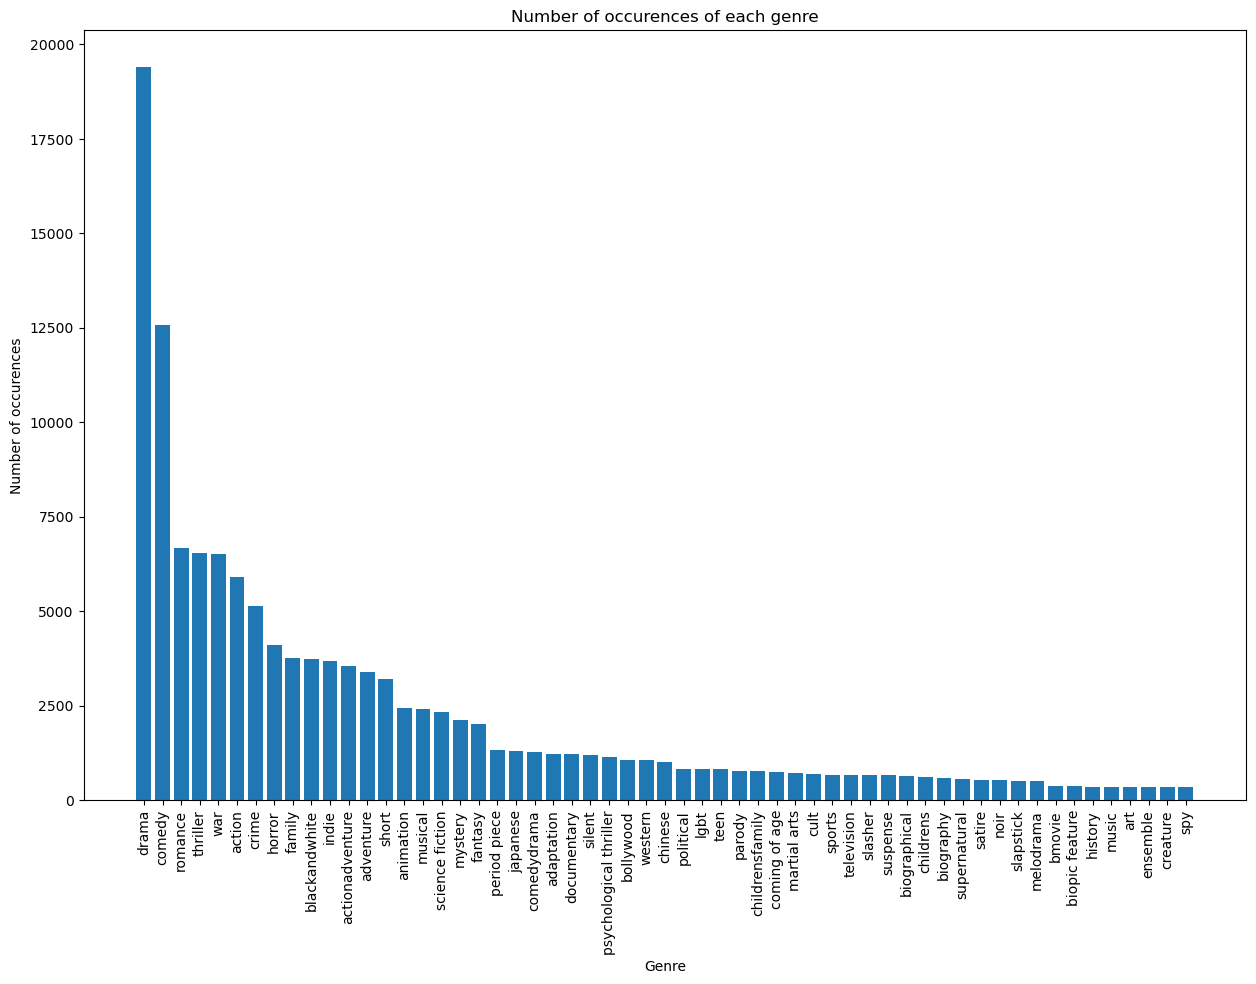

57


In [87]:
#plot the number of occurences of each genre
plt.figure(figsize=(15,10))
plt.bar(df_exploded['genre'].value_counts().index, df_exploded['genre'].value_counts())
plt.title('Number of occurences of each genre')
plt.xlabel('Genre')
#turn x labels 90 degrees
plt.xticks(rotation=90)
plt.ylabel('Number of occurences')
plt.show()
#print number of unique genres
print(len(df_exploded['genre'].unique()))

In [57]:
#save the df to a pickle file
df.to_pickle("./Data/MovieSummaries/plots_genres_reduced_to_60.pkl")

In [63]:
#make coocurence matrix for genres

if not os.path.isfile('Data/MovieSummaries/cooccurrence_matrix.pkl'):
    # Create a list of all genres
    genres = list(set([genre for sublist in df['genre'] for genre in sublist]))

    # Create an empty co-occurrence matrix
    cooccurrence_matrix = pd.DataFrame(index=genres, columns=genres)

    # Fill in the missing values with zeros
    cooccurrence_matrix.fillna(0, inplace=True)

    # Calculate the co-occurrence matrix
    for genre_list in df['genre']:
        for genre_1 in genre_list:
            for genre_2 in genre_list:
                if genre_1 != genre_2:
                    cooccurrence_matrix.loc[genre_1, genre_2] += 1

    # Print the co-occurrence matrix
    cooccurrence_matrix

    #save the cooccurence matrix to a pickle file
    cooccurrence_matrix.to_pickle("./Data/MovieSummaries/cooccurrence_matrix.pkl")

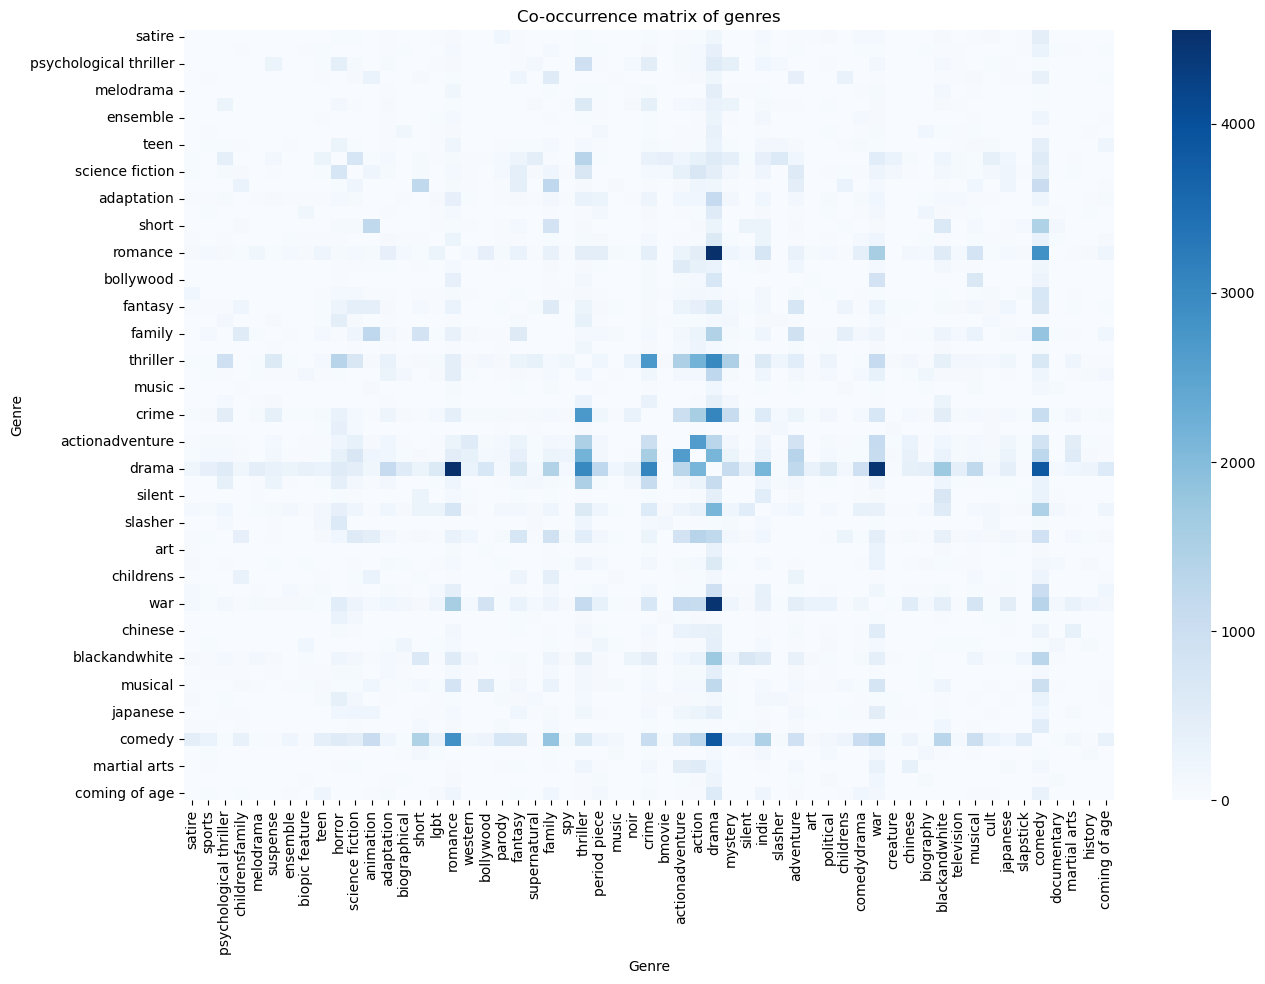

In [64]:
#plot the cooccurence matrix
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(cooccurrence_matrix, annot=False, cmap='Blues')
plt.title('Co-occurrence matrix of genres')
plt.xlabel('Genre')
plt.ylabel('Genre')
plt.show()

In [80]:
# create a balanced dataset with 350 movies per genre
# Create an empty DataFrame
df_balanced = pd.DataFrame(columns=['id', 'text', 'title', 'genre'])

#get the amount of least frequent genre
least_frequent_genre = df_exploded['genre'].value_counts().min()

# Iterate over each genre
for genre in genres:
    # Filter out rows containing the genre
    df_genre = df[df['genre'].apply(lambda x: genre in x)]


    # Randomly select 350 rows from the filtered DataFrame
    if len(df_genre) >= least_frequent_genre:
        df_genre = df_genre.sample(least_frequent_genre, random_state=42)
    else:
        df_genre = df_genre.sample(len(df_genre), random_state=42)


    # Append the selected rows to the DataFrame
    df_balanced = pd.concat([df_balanced, df_genre])



# Shuffle the DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the number of movies per genre
df_balanced['genre'].value_counts()



genre
[documentary]                                                                                134
[short, family, comedy, animation]                                                           131
[japanese]                                                                                    86
[war, musical, drama, romance, bollywood]                                                     81
[silent]                                                                                      74
                                                                                            ... 
[melodrama, drama, adaptation]                                                                 1
[thriller, musical, war, bollywood]                                                            1
[political, drama, documentary]                                                                1
[thriller, science fiction, horror, adventure, supernatural, television, actionadventure]      1
[comedy, silent, adventu

In [81]:
from collections import Counter
flattened_list = [item for sublist in df_balanced['genre'] for item in sublist]

# Step 2: Count the occurrences of each element
element_counts = Counter(flattened_list)
print(len(element_counts))
sorted(element_counts.items(), key=lambda x:x[1], reverse=True)

57


[('drama', 9289),
 ('comedy', 5979),
 ('thriller', 4157),
 ('war', 3800),
 ('action', 3209),
 ('romance', 3122),
 ('crime', 2985),
 ('horror', 2962),
 ('indie', 2553),
 ('actionadventure', 2450),
 ('family', 2368),
 ('adventure', 2295),
 ('blackandwhite', 2113),
 ('mystery', 1634),
 ('science fiction', 1622),
 ('fantasy', 1572),
 ('period piece', 1472),
 ('musical', 1410),
 ('animation', 1368),
 ('adaptation', 1192),
 ('short', 1168),
 ('psychological thriller', 1147),
 ('comedydrama', 1087),
 ('biography', 1024),
 ('teen', 984),
 ('political', 939),
 ('cult', 937),
 ('biographical', 925),
 ('childrensfamily', 908),
 ('japanese', 897),
 ('parody', 888),
 ('childrens', 865),
 ('coming of age', 858),
 ('slasher', 830),
 ('suspense', 805),
 ('lgbt', 802),
 ('chinese', 771),
 ('documentary', 764),
 ('martial arts', 756),
 ('television', 752),
 ('supernatural', 739),
 ('biopic feature', 733),
 ('satire', 713),
 ('silent', 697),
 ('western', 693),
 ('sports', 689),
 ('bmovie', 619),
 ('bolly

In [86]:
#write the balanced df to a pickle file if not already exists
if not os.path.isfile('Data/MovieSummaries/plots_genres_balanced.pkl'):
    df_balanced.to_pickle("./Data/MovieSummaries/plots_genres_balanced.pkl")

19494
dict_values([9289, 5979, 4157, 3800, 3209, 3122, 2985, 2962, 2553, 2450, 2368, 2295, 2113, 1634, 1622, 1572, 1472, 1410, 1368, 1192, 1168, 1147, 1087, 1024, 984, 939, 937, 925, 908, 897, 888, 865, 858, 830, 805, 802, 771, 764, 756, 752, 739, 733, 713, 697, 693, 689, 619, 619, 603, 595, 584, 574, 564, 556, 554, 505, 505])


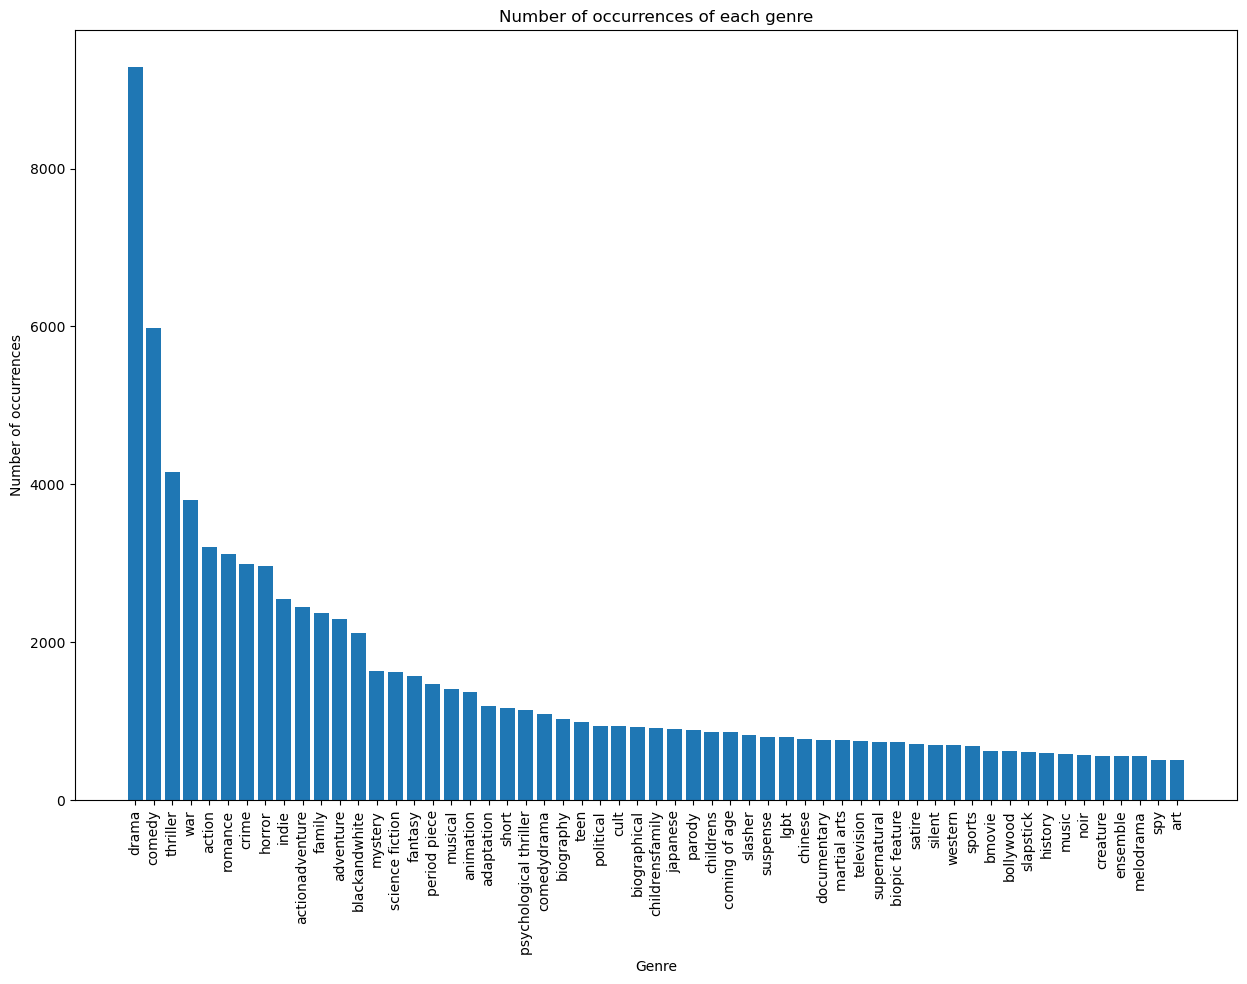

In [96]:
#print the dimensions of the balanced dataset
print(len(df_balanced))

#sort the genres by number of occurences
element_counts = dict(sorted(element_counts.items(), key=lambda x:x[1], reverse=True))



#redo, but turn the ticks 90 degrees
plt.figure(figsize=(15,10))
plt.bar(element_counts.keys(), element_counts.values())
plt.xticks(rotation=90)
plt.title('Number of occurrences of each genre')
plt.xlabel('Genre')
plt.ylabel('Number of occurrences')
plt.show()

In [95]:
9289/505

18.394059405940595

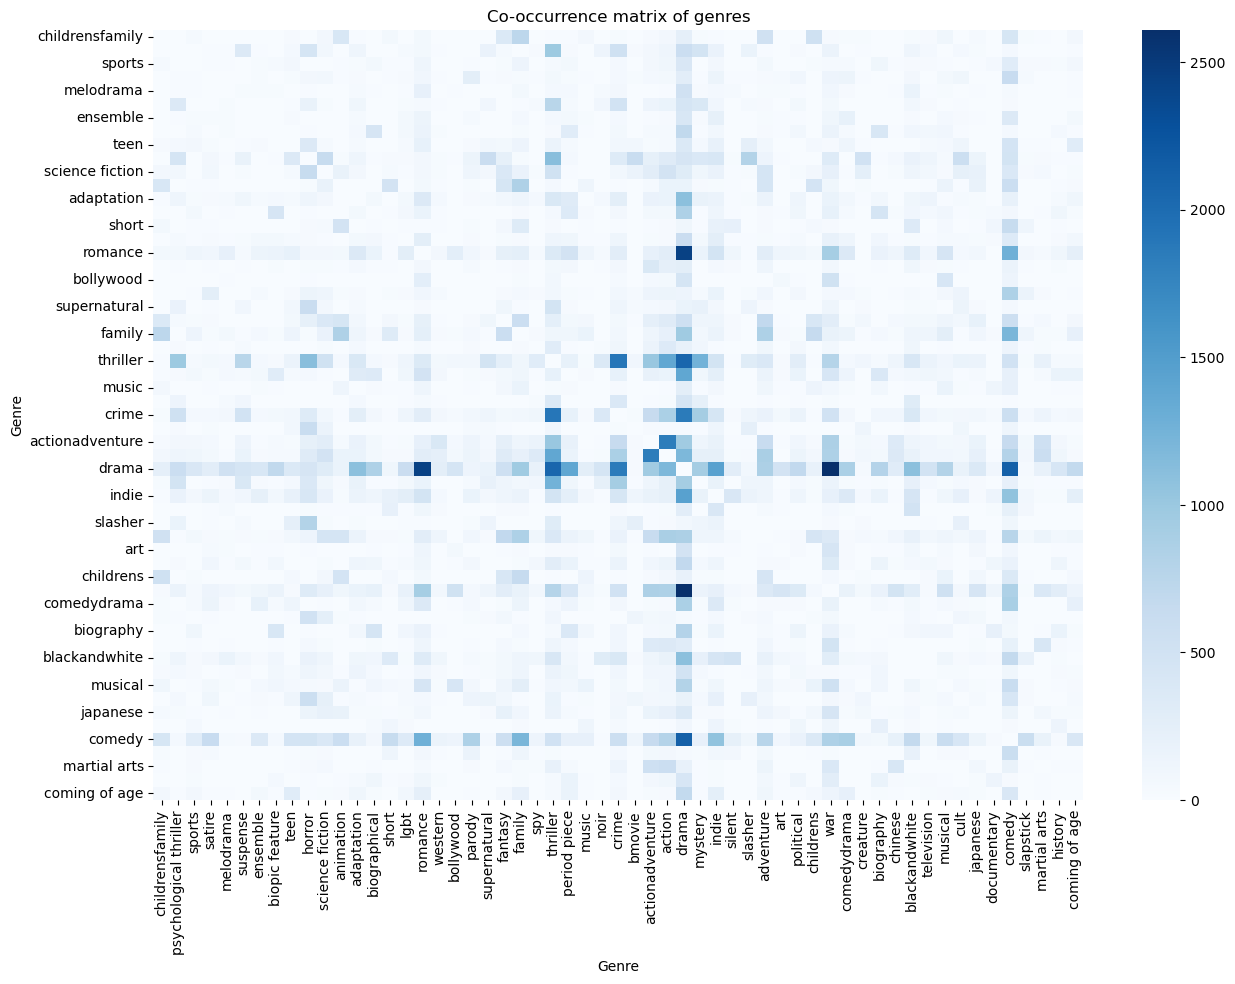

In [85]:
#do the cooccurence matrix again
if not os.path.isfile('Data/MovieSummaries/cooccurrence_matrix_balanced.pkl'):
    # Create a list of all genres
    genres = list(set([genre for sublist in df_balanced['genre'] for genre in sublist]))

    # Create an empty co-occurrence matrix
    cooccurrence_matrix = pd.DataFrame(index=genres, columns=genres)

    # Fill in the missing values with zeros
    cooccurrence_matrix.fillna(0, inplace=True)

    # Calculate the co-occurrence matrix
    for genre_list in df_balanced['genre']:
        for genre_1 in genre_list:
            for genre_2 in genre_list:
                if genre_1 != genre_2:
                    cooccurrence_matrix.loc[genre_1, genre_2] += 1

    # Print the co-occurrence matrix
    cooccurrence_matrix

    #save the cooccurence matrix to a pickle file
    cooccurrence_matrix.to_pickle("./Data/MovieSummaries/cooccurrence_matrix_balanced.pkl")

#plot the cooccurence matrix
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(cooccurrence_matrix, annot=False, cmap='Blues')
plt.title('Co-occurrence matrix of genres')
plt.xlabel('Genre')
plt.ylabel('Genre')
plt.show()